# LHCO Cathode Generation Pipeline
After the particle level models and the jet feature models have been trained, the final step is to run the whole generation pipeline.

## Imports

In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join

import energyflow as ef
import h5py
import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf
from sklearn.neighbors import KernelDensity

2023-10-09 22:17:30.557672: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 22:17:31.292114: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import (
    calculate_all_wasserstein_metrics,
    inverse_normalize_tensor,
    normalize_tensor,
)
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, plot_data, prepare_data_for_plotting

apply_mpl_styles()

In [4]:
# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

In [5]:
data_folder = os.environ.get("DATA_DIR")

# Generate mjj samples
We fit a KDE to the mjj distribution of the signal and background samples. We then sample from the KDE to generate new mjj samples in the signal region.

In [6]:
n_samples = 200_000

In [7]:
path = f"{data_folder}/lhco/final_data/processed_data_background_rel.h5"
with h5py.File(path, "r") as f:
    jets = f["jet_data"][:]

In [8]:
p4_jets = ef.p4s_from_ptyphims(jets)

In [9]:
sum_p4 = p4_jets[:, 0] + p4_jets[:, 1]
mjj = ef.ms_from_p4s(sum_p4)

In [10]:
args_to_keep = ((mjj < 3300) & (mjj > 2300)) | ((mjj > 3700) & (mjj < 5000))
args_to_keep_sr = (mjj > 3300) & (mjj < 3700)

In [11]:
mjj_sb = mjj[args_to_keep]
mjj_sr = mjj[args_to_keep_sr]
args_to_keep_sb_sr = args_to_keep | args_to_keep_sr
mjj_sb_sr = mjj[args_to_keep_sb_sr]

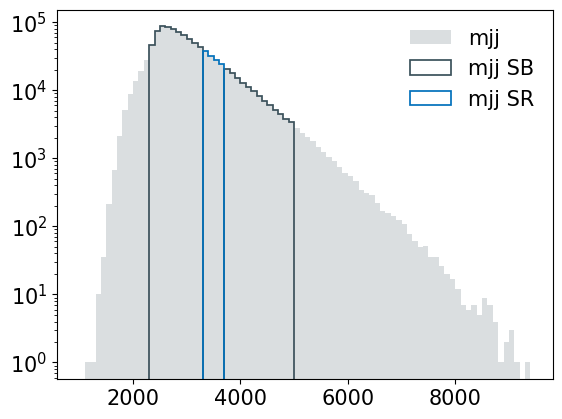

In [12]:
hist = plt.hist(
    mjj, bins=np.arange(1e3, 9.5e3, 0.1e3), histtype="stepfilled", label="mjj", alpha=0.5
)
plt.hist(mjj_sb, bins=hist[1], histtype="step", label="mjj SB")
plt.hist(mjj_sr, bins=hist[1], histtype="step", label="mjj SR")

plt.legend(frameon=False)
plt.yscale("log")
plt.show()

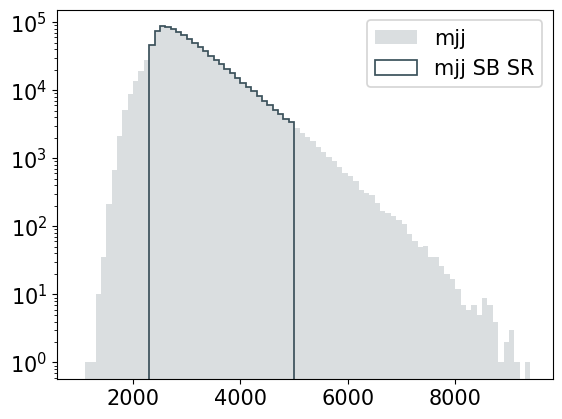

In [13]:
hist = plt.hist(
    mjj, bins=np.arange(1e3, 9.5e3, 0.1e3), histtype="stepfilled", label="mjj", alpha=0.5
)
plt.hist(mjj_sb_sr, bins=hist[1], histtype="step", label="mjj SB SR")

plt.legend()
plt.yscale("log")
plt.show()

### fit KDE on SR and SB

In [14]:
kde_model_sb_sr = KernelDensity(kernel="gaussian", bandwidth=0.001)
kde_model_sb_sr.fit(mjj_sb_sr.reshape(-1, 1))

samples_sb_sr = kde_model_sb_sr.sample(n_samples * 10)

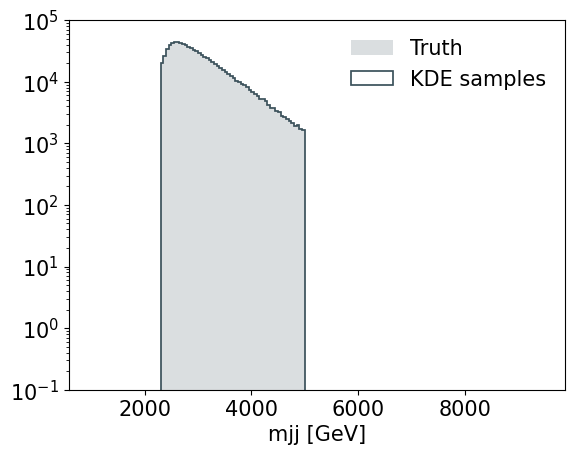

In [15]:
hist = plt.hist(
    mjj_sb_sr,
    bins=np.arange(1e3, 9.5e3, 0.05e3),
    histtype="stepfilled",
    label="Truth",
    alpha=0.5,
)
plt.hist(samples_sb_sr[:len(mjj_sb_sr)], bins=hist[1], histtype="step", label="KDE samples")
plt.xlabel("mjj [GeV]")
plt.ylim(1e-1, 1e5)
plt.legend(frameon=False)
plt.yscale("log")
plt.show()

### only take SR and SB data

In [16]:
args_to_keep_sr_samples = (samples_sb_sr > 3300) & (samples_sb_sr < 3700)
args_to_keep_sb_samples = ((samples_sb_sr < 3300) & (samples_sb_sr > 2300)) | ((samples_sb_sr > 3700) & (samples_sb_sr < 5000))
mjj_samples_sr = samples_sb_sr[args_to_keep_sr_samples]
mjj_samples_sb = samples_sb_sr[args_to_keep_sb_samples]

In [17]:
mjj_samples_sr = mjj_samples_sr[:n_samples]
mjj_samples_sb = mjj_samples_sb[:n_samples]

In [18]:
path_mjj = f"{data_folder}/lhco/generated/mjj_data.h5"

In [19]:
path_mjj_sb = f"{data_folder}/lhco/generated/mjj_data_sb.h5"

In [20]:
# with h5py.File(path_mjj, "w") as f:
#    f.create_dataset("mjj", data=mjj_samples_sr)

In [21]:
#with h5py.File(path_mjj_sb, "w") as f:
#    f.create_dataset("mjj", data=mjj_samples_sb)

In [22]:
with h5py.File(path_mjj, "r") as f:
    mjj_samples_sr = f["mjj"][:]

In [23]:
with h5py.File(path_mjj_sb, "r") as f:
    mjj_samples_sb = f["mjj"][:]

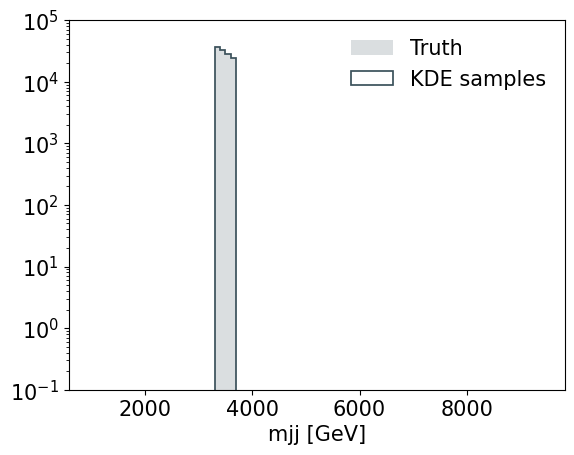

In [24]:
hist = plt.hist(
    mjj_sr,
    bins=np.arange(1e3, 9.5e3, 0.1e3),
    histtype="stepfilled",
    label="Truth",
    alpha=0.5,
)
plt.hist(mjj_samples_sr[:len(mjj_sr)], bins=hist[1], histtype="step", label="KDE samples")
plt.ylim(1e-1, 1e5)
plt.xlabel("mjj [GeV]")
plt.legend(frameon=False)
plt.yscale("log")
plt.show()

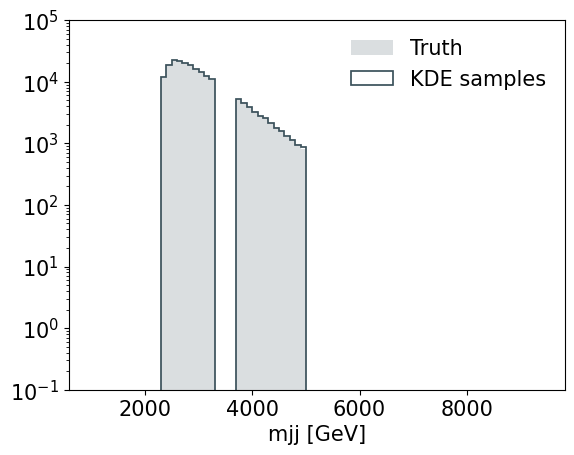

In [25]:
hist = plt.hist(
    mjj_sb[:len(mjj_samples_sb)],
    bins=np.arange(1e3, 9.5e3, 0.1e3),
    histtype="stepfilled",
    label="Truth",
    alpha=0.5,
)
plt.hist(mjj_samples_sb, bins=hist[1], histtype="step", label="KDE samples")
plt.ylim(1e-1, 1e5)
plt.xlabel("mjj [GeV]")
plt.legend(frameon=False)
plt.yscale("log")
plt.show()

# Generate from Jet Feature Model

### Load model

In [26]:
experiment = "/lhco/lhco_jet_features.yaml"

In [27]:
# load everything from experiment config
with hydra.initialize(version_base=None, config_path="../configs/"):
    #cfg = hydra.compose(config_name="train.yaml")
    cfg = hydra.compose(config_name="train.yaml", overrides=[f"experiment={experiment}"])
    print(OmegaConf.to_yaml(cfg))

task_name: lhco_flow_matching_jet_features
tags:
- flow_matching
- LHCO
- jet_features
train: true
test: true
compile: false
ckpt_path: null
seed: 12345
data:
  _target_: src.data.lhco_jet_feature_datamodule.LHCOJetFeatureDataModule
  data_dir: ${paths.data_dir}
  batch_size: 1024
  num_workers: 32
  pin_memory: false
  val_fraction: 0.05
  test_fraction: 0.35
  normalize: true
model:
  _target_: src.models.flow_matching_no_sets.FLowMatchingNoSetsLitModule
  optimizer:
    _target_: torch.optim.AdamW
    _partial_: true
    lr: 0.001
  scheduler:
    _target_: torch.optim.lr_scheduler.ConstantLR
    _partial_: true
  features: 10
callbacks:
  model_checkpoint:
    _target_: src.callbacks.ema.EMAModelCheckpoint
    dirpath: ${paths.output_dir}/checkpoints
    filename: epoch_{epoch:03d}_loss_{val/loss:.5f}
    monitor: val/loss
    verbose: false
    save_last: true
    save_top_k: 5
    mode: min
    auto_insert_metric_name: false
    save_weights_only: false
    every_n_train_steps: n

In [28]:
datamodule = hydra.utils.instantiate(cfg.data)
model = hydra.utils.instantiate(cfg.model)

In [29]:
datamodule.setup()

217119 events are removed due to the window cut.
Train dataset size: 469729
Validation dataset size: 39144
Test dataset size: 274008


In [30]:
test_data_sr = np.array(datamodule.tensor_test_sr)
test_cond_sr = np.array(datamodule.tensor_conditioning_test_sr)
val_data_sr = np.array(datamodule.tensor_val_sr)
val_cond_sr = np.array(datamodule.tensor_conditioning_val_sr)
train_data_sr = np.array(datamodule.tensor_train_sr)
train_cond_sr = np.array(datamodule.tensor_conditioning_train_sr)
means = np.array(datamodule.means)
stds = np.array(datamodule.stds)
means_cond = np.array(datamodule.cond_means)
stds_cond = np.array(datamodule.cond_stds)

In [31]:
test_data_sb = np.array(datamodule.tensor_test)
test_cond_sb = np.array(datamodule.tensor_conditioning_test)
val_data_sb = np.array(datamodule.tensor_val)
val_cond_sb = np.array(datamodule.tensor_conditioning_val)
train_data_sb = np.array(datamodule.tensor_train)
train_cond_sb = np.array(datamodule.tensor_conditioning_train)

### Load checkpoint

In [32]:
# Insert checkpoint path here
ckpt = ".../last-EMA.ckpt"
model = model.load_from_checkpoint(ckpt)

### Generate Data

In [33]:
# normalize conditioning variables
normalized_cond = normalize_tensor(
    torch.tensor(mjj_samples_sr.copy(), dtype=torch.float).clone().unsqueeze(-1),
    means_cond,
    stds_cond,
    datamodule.hparams.normalize_sigma,
)

In [34]:
# normalize conditioning variables
normalized_cond_sb = normalize_tensor(
    torch.tensor(mjj_samples_sb.copy(), dtype=torch.float).clone().unsqueeze(-1),
    means_cond,
    stds_cond,
    datamodule.hparams.normalize_sigma,
)

In [35]:
torch.manual_seed(9999)
data_jet_feature_temp, generation_time = generate_data(
    model,
    num_jet_samples=n_samples,
    batch_size=2048,
    cond=normalized_cond[:n_samples],
    normalized_data=datamodule.hparams.normalize,
    normalize_sigma=datamodule.hparams.normalize_sigma,
    means=datamodule.means,
    stds=datamodule.stds,
    ode_solver="midpoint",
    ode_steps=250,
)

Generating data (200000 samples). Device: cuda


  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 97/97 [01:16<00:00,  1.27it/s]


In [36]:
torch.manual_seed(9999)
data_jet_feature_temp_sb, generation_time = generate_data(
    model,
    num_jet_samples=n_samples,
    batch_size=2048,
    cond=normalized_cond_sb[:n_samples],
    normalized_data=datamodule.hparams.normalize,
    means=datamodule.means,
    stds=datamodule.stds,
    ode_solver="midpoint",
    ode_steps=250,
)

Generating data (200000 samples). Device: cuda


  0%|          | 0/97 [00:00<?, ?it/s]

100%|██████████| 97/97 [01:14<00:00,  1.31it/s]


### Postprocessing

In [37]:
# shift phi values to [-pi, pi]
data_jet_feature_temp[:, 2][data_jet_feature_temp[:, 2] > np.pi] -= 2 * np.pi
data_jet_feature_temp[:, 2][data_jet_feature_temp[:, 2] < -np.pi] += 2 * np.pi
data_jet_feature_temp[:, 7][data_jet_feature_temp[:, 7] > np.pi] -= 2 * np.pi
data_jet_feature_temp[:, 7][data_jet_feature_temp[:, 7] < -np.pi] += 2 * np.pi

In [38]:
# shift phi values to [-pi, pi]
data_jet_feature_temp_sb[:, 2][data_jet_feature_temp_sb[:, 2] > np.pi] -= 2 * np.pi
data_jet_feature_temp_sb[:, 2][data_jet_feature_temp_sb[:, 2] < -np.pi] += 2 * np.pi
data_jet_feature_temp_sb[:, 7][data_jet_feature_temp_sb[:, 7] > np.pi] -= 2 * np.pi
data_jet_feature_temp_sb[:, 7][data_jet_feature_temp_sb[:, 7] < -np.pi] += 2 * np.pi

In [39]:
# clip particle multiplicity
data_jet_feature_temp[:, 4][data_jet_feature_temp[:, 4] < 1] = 1
data_jet_feature_temp[:, 4][data_jet_feature_temp[:, 4] > 279] = 279
data_jet_feature_temp[:, 9][data_jet_feature_temp[:, 9] < 1] = 1
data_jet_feature_temp[:, 9][data_jet_feature_temp[:, 9] > 279] = 279
data_jet_feature = data_jet_feature_temp

In [40]:
# clip particle multiplicity
data_jet_feature_temp_sb[:, 4][data_jet_feature_temp_sb[:, 4] < 1] = 1
data_jet_feature_temp_sb[:, 4][data_jet_feature_temp_sb[:, 4] > 279] = 279
data_jet_feature_temp_sb[:, 9][data_jet_feature_temp_sb[:, 9] < 1] = 1
data_jet_feature_temp_sb[:, 9][data_jet_feature_temp_sb[:, 9] > 279] = 279
data_jet_feature_sb = data_jet_feature_temp_sb

In [41]:
# get mask from particle multiplicity
n_classes_x = 279
mask_x_ints = data_jet_feature[:, 4]
targets_x = np.rint(mask_x_ints).astype(int)
mask_x = np.expand_dims(np.tril(np.ones((n_classes_x, n_classes_x)), k=-1)[targets_x], axis=-1)

In [42]:
# get mask from particle multiplicity sideband
n_classes_x_sb = 279
mask_x_ints_sb = data_jet_feature_sb[:, 4]
targets_x_sb = np.rint(mask_x_ints_sb).astype(int)
mask_x_sb = np.expand_dims(np.tril(np.ones((n_classes_x_sb, n_classes_x_sb)), k=-1)[targets_x_sb], axis=-1)

In [43]:
# get mask from particle multiplicity jet 2
n_classes_y = 279
mask_y_ints = data_jet_feature[:, 9]
targets_y = np.rint(mask_y_ints).astype(int)
mask_y = np.expand_dims(np.tril(np.ones((n_classes_y, n_classes_y)), k=-1)[targets_y], axis=-1)

In [44]:
# get mask from particle multiplicity sideband jet 2
n_classes_y_sb = 279
mask_y_ints_sb = data_jet_feature_sb[:, 9]
targets_y_sb = np.rint(mask_y_ints_sb).astype(int)
mask_y_sb = np.expand_dims(np.tril(np.ones((n_classes_y_sb, n_classes_y_sb)), k=-1)[targets_y_sb], axis=-1)

In [45]:
data_jet_feature_temp[:, 4] = np.rint(data_jet_feature_temp[:, 4])
data_jet_feature_temp[:, 9] = np.rint(data_jet_feature_temp[:, 9])

In [46]:
data_jet_feature_temp_sb[:, 4] = np.rint(data_jet_feature_temp_sb[:, 4])
data_jet_feature_temp_sb[:, 9] = np.rint(data_jet_feature_temp_sb[:, 9])

### Save Data

In [47]:
path_jet_features_full = f"{data_folder}/lhco/generated/jet_features_full.h5"
#with h5py.File(path_jet_features_full, "w") as f:
#    f.create_dataset("jet_features_x", data=data_jet_feature[..., :5])
#    f.create_dataset("jet_features_y", data=data_jet_feature[..., 5:])
#    f.create_dataset("mask_x", data=mask_x)
#    f.create_dataset("mask_y", data=mask_y)
#    f.create_dataset("mjj", data=mjj_samples_sr)

In [48]:
path_jet_features_full_sb = f"{data_folder}/lhco/generated/jet_features_full_sb.h5"
#with h5py.File(path_jet_features_full_sb, "w") as f:
#    f.create_dataset("jet_features_x", data=data_jet_feature_sb[..., :5])
#    f.create_dataset("jet_features_y", data=data_jet_feature_sb[..., 5:])
#    f.create_dataset("mask_x", data=mask_x_sb)
#    f.create_dataset("mask_y", data=mask_y_sb)
#    f.create_dataset("mjj", data=mjj_samples_sb)

In [49]:
with h5py.File(path_jet_features_full, "r") as f:
    data_jet_feature = np.concatenate(
        [f["jet_features_x"][:], f["jet_features_y"][:]], axis=-1
    )
    mask_x = f["mask_x"][:]
    mask_y = f["mask_y"][:]
    mjj_samples_sr2 = f["mjj"][:]

In [50]:
with h5py.File(path_jet_features_full_sb, "r") as f:
    data_jet_feature_sb = np.concatenate(
        [f["jet_features_x"][:], f["jet_features_y"][:]], axis=-1
    )
    mask_x_sb = f["mask_x"][:]
    mask_y_sb = f["mask_y"][:]
    mjj_samples_sr2_sb = f["mjj"][:]

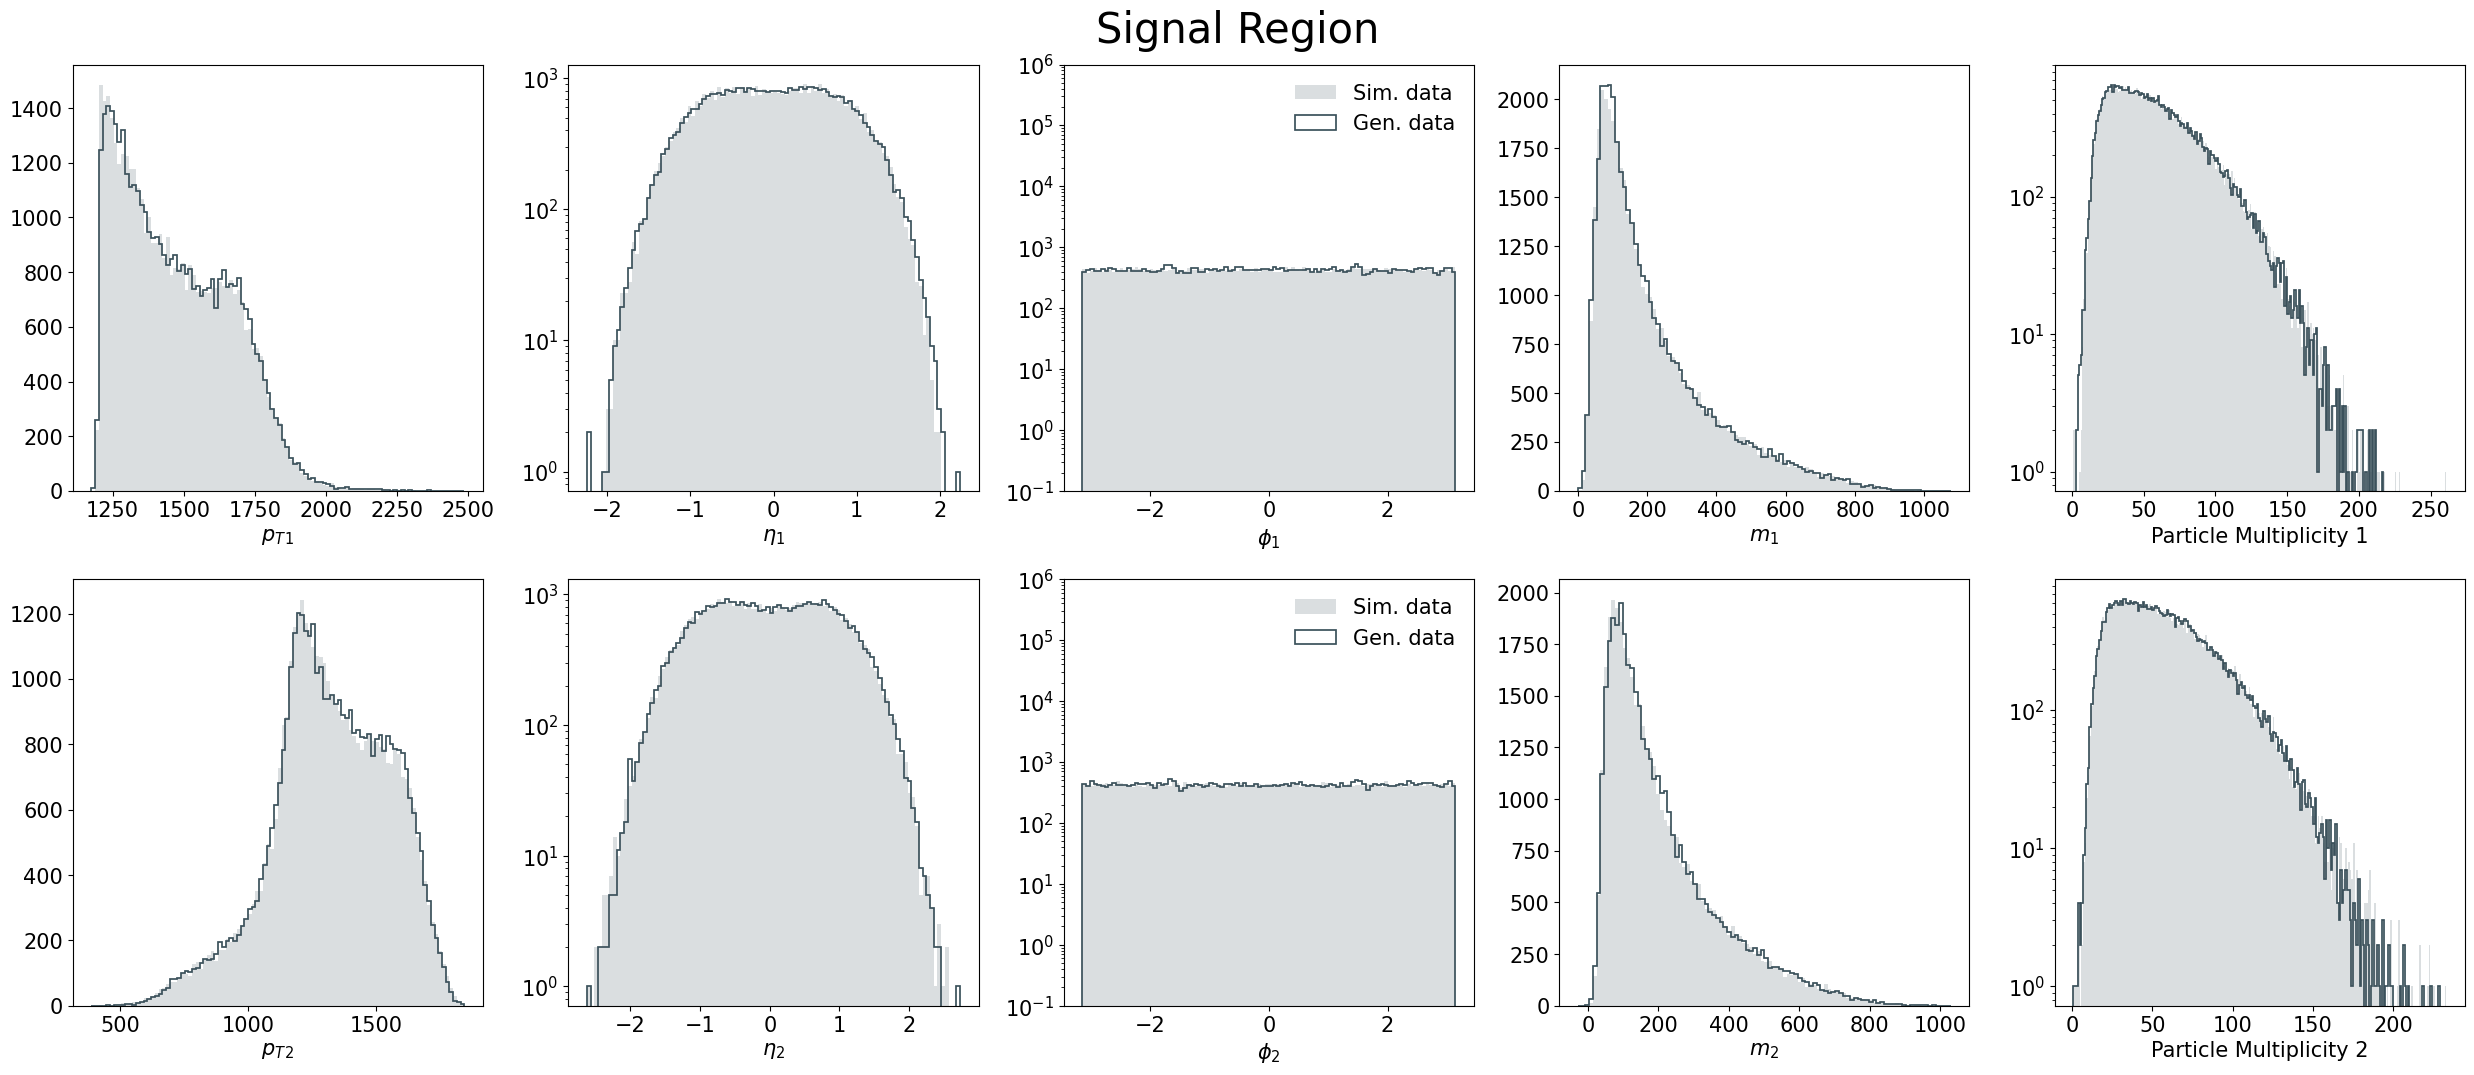

In [51]:
plot_samples = min(n_samples, len(test_data_sr))
label_map = {
    "0": r"${p_T}_1$",
    "1": r"$\eta_1$",
    "2": r"$\phi_1$",
    "3": r"$m_1$",
    "4": "Particle Multiplicity 1",
    "5": r"${p_T}_2$",
    "6": r"$\eta_2$",
    "7": r"$\phi_2$",
    "8": r"$m_2$",
    "9": "Particle Multiplicity 2",
}
fig, axs = plt.subplots(2, 5, figsize=(25, 11))
for index, ax in enumerate(axs.reshape(-1)):
    x_min, x_max = min(
        np.min(test_data_sr[:plot_samples, index]), np.min(data_jet_feature[:plot_samples, index])
    ), max(
        np.max(test_data_sr[:plot_samples, index]), np.max(data_jet_feature[:plot_samples, index])
    )
    if index == 4 or index == 9:
        bin_width = 1
        bins = range(int(x_min), int(x_max) + bin_width, bin_width)
    else:
        bins = 100
    hist1 = ax.hist(
        test_data_sr[:plot_samples, index],
        bins=bins,
        label="Sim. data",
        range=[x_min, x_max],
        alpha=0.5,
    )
    ax.hist(
        data_jet_feature[:plot_samples, index], bins=hist1[1], label="Gen. data", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    if index == 1 or index == 2 or index == 4 or index == 6 or index == 7 or index == 9:
        ax.set_yscale("log")
    if index == 2 or index == 7:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.suptitle("Signal Region", fontsize=30)
fig.subplots_adjust(top=0.93)
plt.show()

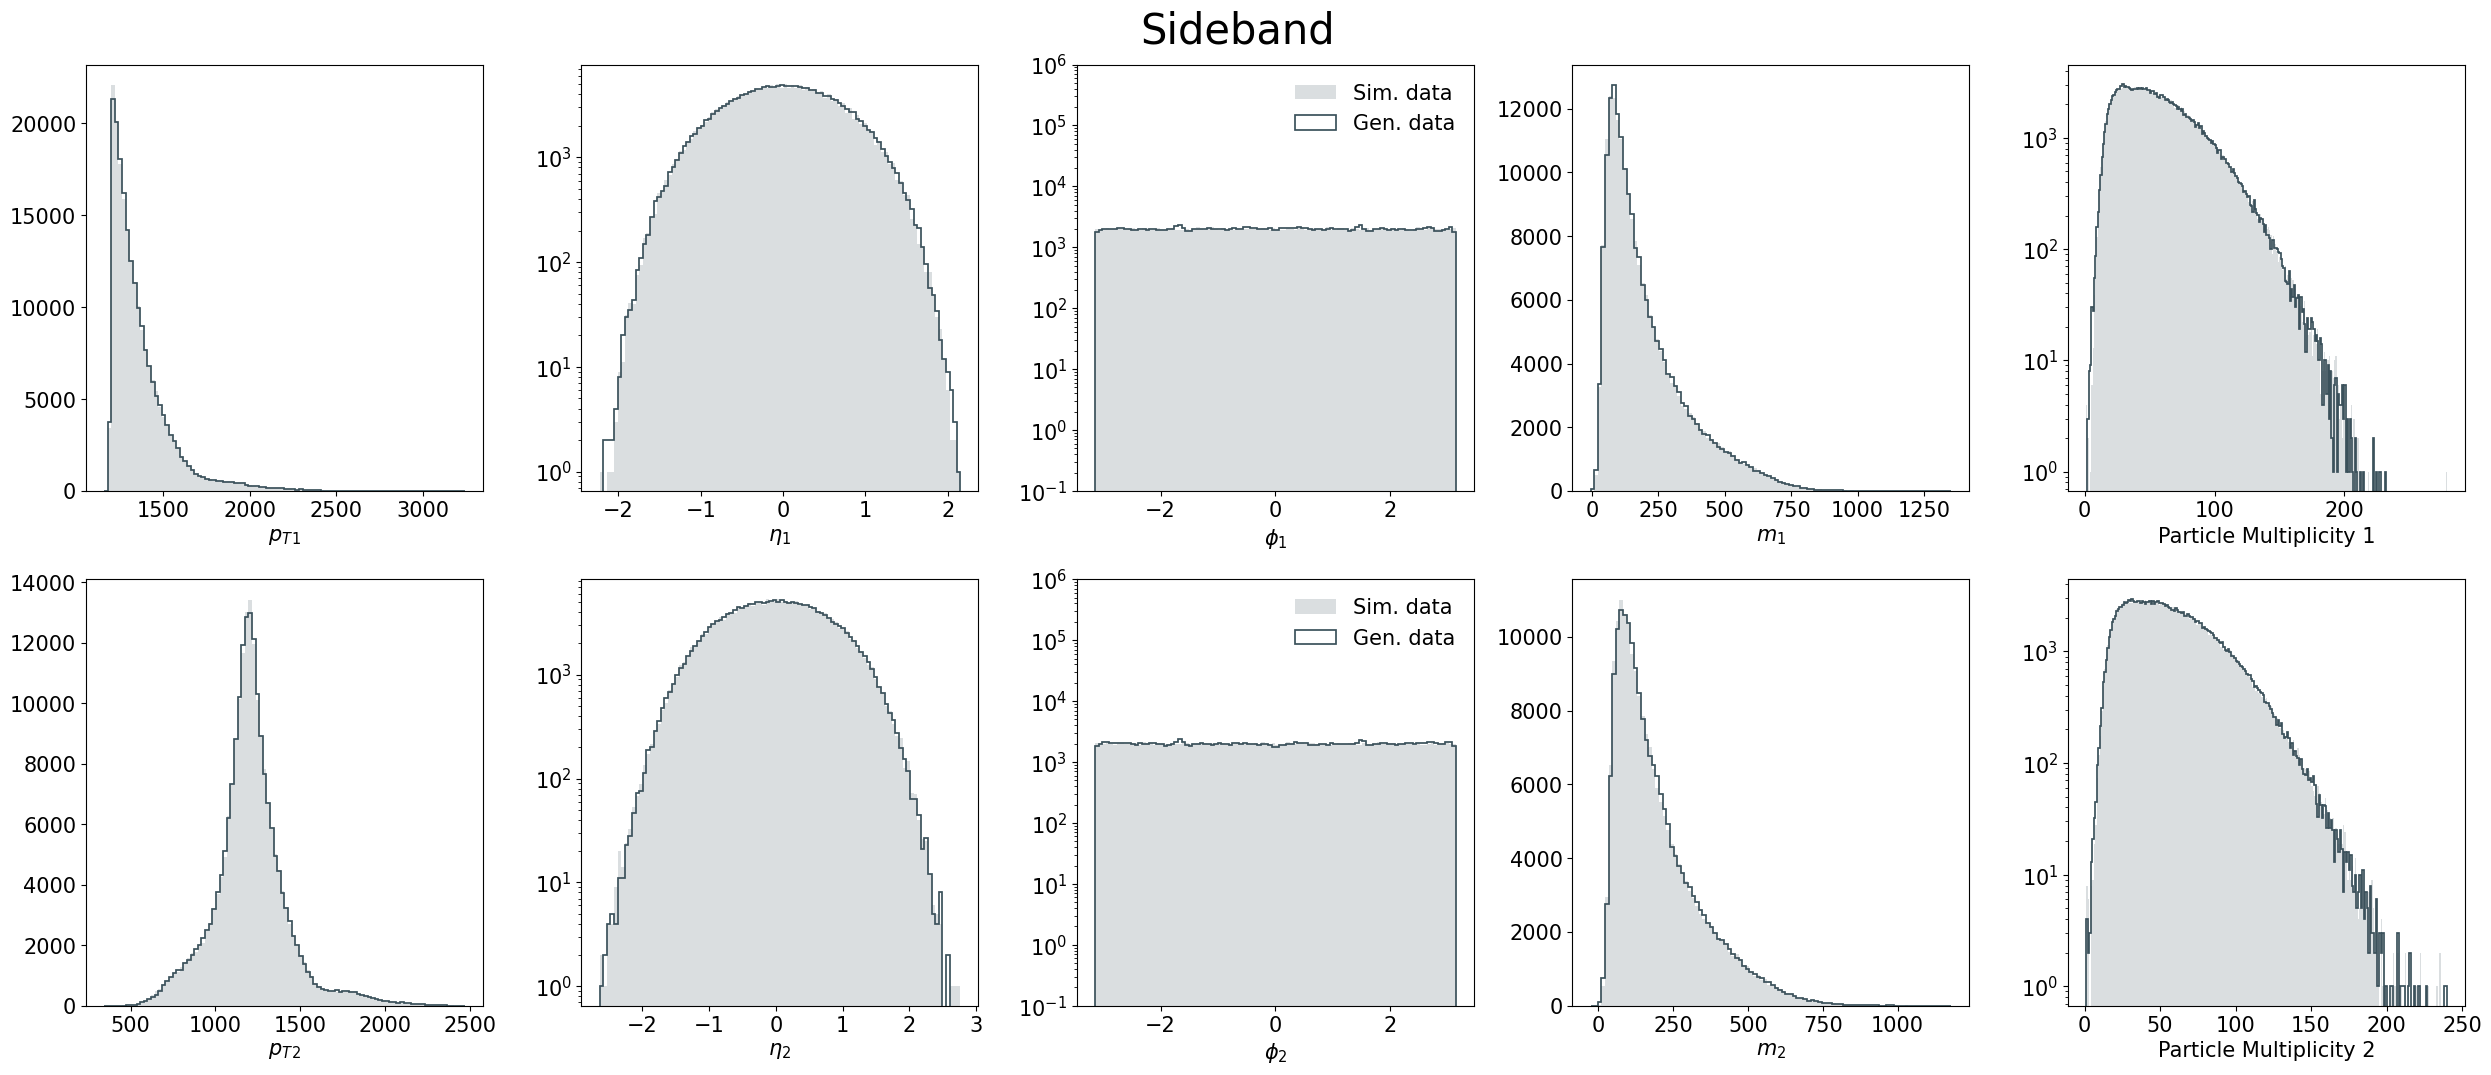

In [52]:
plot_samples = min(n_samples, len(test_data_sb))
label_map = {
    "0": r"${p_T}_1$",
    "1": r"$\eta_1$",
    "2": r"$\phi_1$",
    "3": r"$m_1$",
    "4": "Particle Multiplicity 1",
    "5": r"${p_T}_2$",
    "6": r"$\eta_2$",
    "7": r"$\phi_2$",
    "8": r"$m_2$",
    "9": "Particle Multiplicity 2",
}
fig, axs = plt.subplots(2, 5, figsize=(25, 11))
for index, ax in enumerate(axs.reshape(-1)):
    x_min, x_max = min(
        np.min(test_data_sb[:plot_samples, index]), np.min(data_jet_feature_sb[:plot_samples, index])
    ), max(
        np.max(test_data_sb[:plot_samples, index]), np.max(data_jet_feature_sb[:plot_samples, index])
    )
    if index == 4 or index == 9:
        bin_width = 1
        bins = range(int(x_min), int(x_max) + bin_width, bin_width)
    else:
        bins = 100
    hist1 = ax.hist(
        test_data_sb[:plot_samples, index],
        bins=bins,
        label="Sim. data",
        range=[x_min, x_max],
        alpha=0.5,
    )
    ax.hist(
        data_jet_feature_sb[:plot_samples, index], bins=hist1[1], label="Gen. data", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    if index == 1 or index == 2 or index == 4 or index == 6 or index == 7 or index == 9:
        ax.set_yscale("log")
    if index == 2 or index == 7:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
plt.suptitle("Sideband", fontsize=30)
fig.subplots_adjust(top=0.93)
plt.show()

# Particle Feature Model
Generating from the Particle Feature Model takes some time. Therefore a separate script in the `scripts` folder is provided to generate the data.